In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

In [2]:
cl_storedata = pd.read_csv('Cl_Stored_Data.csv', na_values=['?', None, 'undefined'])
cl_traindata = pd.read_csv('cl.traindata.csv', na_values=['?', None, 'undefined'])
cl_testdata = pd.read_csv('cl.testdata.csv', na_values=['?', None, 'undefined'])
submission_data = pd.read_csv('sample_submission.csv', na_values=['?', None, 'undefined'])

In [3]:
cl_storedata.info(), cl_traindata.info(), cl_testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   float64
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
-

(None, None, None)

In [4]:
cl_storedata.fillna(0, inplace=True)

In [5]:
# how many missing values exist or better still what is the % of missing values in the dataset?
def percent_missing(df, data_type):

    # Calculate total number of cells in dataframe
    totalCells = np.product(df.shape)

    # Count number of missing values per column
    missingCount = df.isnull().sum()

    # Calculate total number of missing values
    totalMissing = missingCount.sum()

    # Calculate percentage of missing values
    print(f"The {data_type} dataset contains", round(((totalMissing/totalCells) * 100), 2), "%", "missing values.")

percent_missing(cl_storedata, 'store')
percent_missing(cl_traindata, 'train')
percent_missing(cl_testdata, 'test')

The store dataset contains 0.0 % missing values.
The train dataset contains 0.0 % missing values.
The test dataset contains 0.0 % missing values.


***Preprocessing***

In [6]:
#find the date part of the DatetimeIndex object.
def holiday(x):
    if x in ['a','b','c']:
        return 1
    return 0
    
def day_month_year(df, col):
    try:
        df['Day'] = pd.DatetimeIndex(df[col]).day
        df['Month'] = pd.DatetimeIndex(df[col]).month
        df['Year'] = pd.DatetimeIndex(df[col]).year
    except KeyError:
        print("Unknown Column Index")
    
cl_traindata['Holiday'] = cl_traindata['StateHoliday'].apply(holiday)
cl_testdata['Holiday'] = cl_testdata['StateHoliday'].apply(holiday)
cl_traindata['Holiday'] = cl_traindata['Holiday'] | cl_traindata['SchoolHoliday']
cl_testdata['Holiday'] = cl_testdata['Holiday'] | cl_testdata['SchoolHoliday']
day_month_year(cl_traindata, 'Date') 
day_month_year(cl_testdata, 'Date')

In [7]:
# drop missing value
cl_testdata = cl_testdata.dropna()
cl_traindata = cl_traindata.dropna()

In [8]:
def weekends(x):
    if x >= 6:
        return 1
    return 0

def time_of_month(x):
    if x <= 10:
        return 0
    if x <= 20:
        return 1
    return 2

def label_holidays(x):
    if x in [0,'0','a','b','c']:
        return [0,'0','a','b','c'].index(x)
    return 5

def days_from_holiday(dates, holidays):
    days_till, days_after = [], []
    for day in dates:
        ind = bisect.bisect(holidays, day)
        if ind == 0:
            days_till.append((holidays[ind] - day).days)
            days_after.append(14)
        elif ind == len(holidays):
            days_till.append(14)
            days_after.append((day - holidays[ind - 1]).days)
        else:
            days_till.append((day - holidays[ind - 1]).days)
            days_after.append((holidays[ind] - day).days)
    return days_till, days_after

# change data formate 
cl_traindata['Weekend'] = cl_traindata['DayOfWeek'].apply(weekends)
cl_testdata['Weekend'] = cl_testdata['DayOfWeek'].apply(weekends)
cl_traindata['TimeOfMonth'] = cl_traindata['Day'].apply(time_of_month)
cl_testdata['TimeOfMonth'] = cl_testdata['Day'].apply(time_of_month)
cl_traindata['Holiday'] = cl_traindata['StateHoliday'].apply(label_holidays)
cl_testdata['Holiday'] = cl_testdata['StateHoliday'].apply(label_holidays)
cl_traindata['Date'] = pd.DatetimeIndex(cl_traindata['Date'])
cl_testdata['Date'] = pd.DatetimeIndex(cl_testdata['Date'])

**Analysis**

In [9]:
# Correlation between Sales and number of customers
cl_traindata[['Customers','Sales']].corr()

,Customers,Sales
Customers,1.000000,0.894711
Sales,0.894711,1.000000


In [10]:
# Correlation between promo and sales
cl_traindata[['Promo','Sales']].corr()

,Promo,Sales
Promo,1.000000,0.452345
Sales,0.452345,1.000000


In [11]:
# Correlation between promo, Customers and sales
cl_traindata[['Promo', 'Customers','Sales']].corr()

,Promo,Customers,Sales
Promo,1.000000,0.316169,0.452345
Customers,0.316169,1.000000,0.894711
Sales,0.452345,0.894711,1.000000


In [12]:
# stores opened in weekdays (open = 1)
week_data = cl_traindata[['Store', 'DayOfWeek','Open', 'Sales','Customers']]
week_data = week_data[week_data['Open'] == 1]
store_open_weekdays = week_data[['Store', 'DayOfWeek']].groupby('Store').nunique()
store_open_weekdays = store_open_weekdays[store_open_weekdays['DayOfWeek'] == 7].reset_index()
store_open_weekdays

,Store,DayOfWeek
0,85,7
1,122,7
2,209,7
3,259,7
4,262,7
5,274,7
6,299,7
7,310,7
8,335,7
9,353,7


In [13]:
promo_sale = cl_traindata[['Promo','Sales']].groupby('Promo').mean().reset_index()
promo_sale

,Promo,Sales
0,0,4406.050805
1,1,7991.152046


In [14]:
promo_customers = cl_traindata[['Promo','Customers']].groupby('Promo').mean().reset_index()
promo_customers

,Promo,Customers
0,0,517.823542
1,1,820.098815


In [15]:
week_data = week_data[week_data['Store'].isin(set(week_data['Store']))]
weekendstores = set(week_data['Store'])
def isallweekstore(x):
    return (1 if x in weekendstores else 0)

cl_traindata['7DayStore'] = cl_traindata['Store'].apply(isallweekstore)
cl_testdata['7DayStore'] = cl_testdata['Store'].apply(isallweekstore)

In [16]:
import bisect 
cl_traindata = cl_traindata.merge(cl_storedata, on='Store', how='left')
cl_testdata = cl_testdata.merge(cl_storedata, on='Store', how='left')
holidays = np.array(cl_traindata[cl_traindata["Holiday"] > 1]["Date"].unique())
holidays = np.sort(holidays)
cl_traindata["TillHday"], cl_traindata["AfterHday"] = days_from_holiday(cl_traindata["Date"], holidays)
holidays = np.array(cl_testdata[cl_testdata["Holiday"] > 1]["Date"].unique())
holidays = np.sort(holidays)
cl_testdata["TillHday"], cl_testdata["AfterHday"] = days_from_holiday(cl_testdata["Date"], holidays)

In [17]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
le = LabelEncoder()

cl_traindata['StoreType'] = le.fit_transform(cl_traindata['StoreType'])
cl_traindata['Assortment'] = le.fit_transform(cl_traindata['Assortment'])
cl_testdata['StoreType'] = le.fit_transform(cl_testdata['StoreType'])
cl_testdata['Assortment'] = le.fit_transform(cl_testdata['Assortment'])

In [18]:
cl_testdata[['TillHday','AfterHday']].sample(5)

,TillHday,AfterHday
145,14,33
40018,13,14
400,14,33
33819,6,14
1082,14,32


In [19]:
from sklearn.preprocessing import StandardScaler
x = cl_traindata[['Store', 'DayOfWeek', 'Open', 'Promo', 'Holiday', 'SchoolHoliday', 'Day',
              'Month', 'Year', 'Weekend' ,'TimeOfMonth', '7DayStore','StoreType',
              'Assortment','CompetitionDistance', 'Promo2', 'TillHday', 'AfterHday']]

y_scaler = StandardScaler()
y = y_scaler.fit_transform(cl_traindata[['Sales']].values)
train_features = x.columns
x = x.values

In [20]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from datetime import datetime
import mlflow
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

Linear Regression Pipeline with k=5


2024/02/06 00:40:13 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



score: 0.5552640206805541
mean squared error: 0.4437421796220571
------------------------------------------------------
score: 0.5544364673480213
mean squared error: 0.4462070697647286
------------------------------------------------------
score: 0.5559953482377504
mean squared error: 0.4459952135231427
------------------------------------------------------
score: 0.5571448495536442
mean squared error: 0.44135540078369695
------------------------------------------------------
score: 0.552649628558272
mean squared error: 0.447202544135036
------------------------------------------------------
r2 score: 0.552649628558272
mean squared error: 0.447202544135036


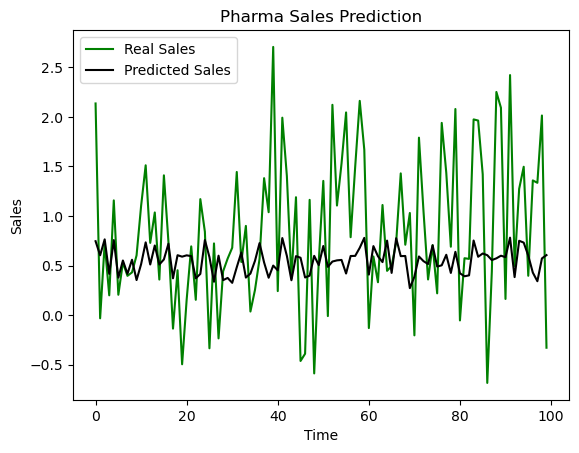

Random Forest Regressor with k=5
score: 0.905852660673692
mean squared error: 0.09393695923186272
------------------------------------------------------
score: 0.9082783665634653
mean squared error: 0.09185410898902698
------------------------------------------------------
score: 0.9070349042819568
mean squared error: 0.09338187685738408
------------------------------------------------------
score: 0.91058410838163
mean squared error: 0.08911308052278764
------------------------------------------------------
score: 0.9046739805291064
mean squared error: 0.09529451890754186
------------------------------------------------------
r2 score: 0.9046739805291064
mean squared error: 0.09529451890754186


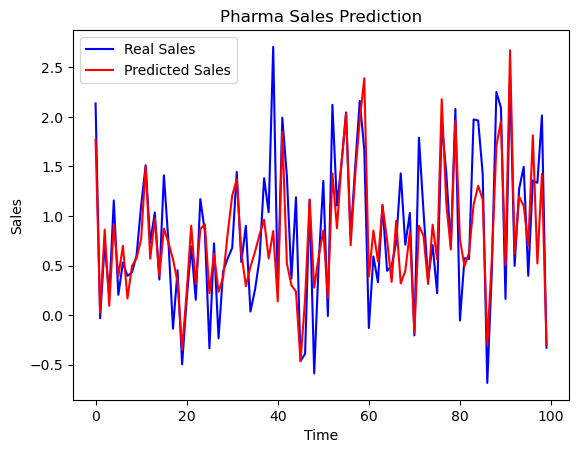

In [22]:
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Set MLflow Tracking URI
mlflow.set_tracking_uri("file:///C:/Users/Admin/AI%20course%20Digicrome/Assignment/Work%20sheet/Pharmaceutical%20Sales%20prediction%20across%20multiple%20stores/mlruns")

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Linear Regression
print("Linear Regression Pipeline with k=5")
for train_index, test_index in kf.split(x):
    with mlflow.start_run(run_name='linear_kfold', nested=True):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        reg_pipe = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
        reg_pipe.fit(X_train, y_train)
        score = reg_pipe.score(X_test, y_test)
        mse = mean_squared_error(y_test, reg_pipe.predict(X_test))
        print("score:", score)
        print("mean squared error:", mse)
        print("------------------------------------------------------")
        mlflow.log_param("lin_reg_score", score)
        mlflow.log_param("lin_reg_mse", mse)
        
        # Save the model as an artifact
        mlflow.sklearn.log_model(reg_pipe, "model")
        
        mlflow.end_run()

        y_pred = reg_pipe.predict(X_test)

print('r2 score:', r2_score(y_test, y_pred))
print('mean squared error:', mean_squared_error(y_test, y_pred))
plt.plot(y_test[:100], color='green', label='Real Sales')
plt.plot(y_pred[:100], color='black', label='Predicted Sales')
plt.title('Pharma Sales Prediction')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Random Forest Regressor
print("Random Forest Regressor with k=5")
for train_index, test_index in kf.split(x):
    with mlflow.start_run(run_name='random_forest_reg_kfold', nested=True):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        forest_pipe = Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(n_estimators=8, max_depth=20))])
        forest_pipe.fit(X_train, y_train)
        score = forest_pipe.score(X_test, y_test)
        mse = mean_squared_error(y_test, forest_pipe.predict(X_test))
        print("score:", score)
        print("mean squared error:", mse)
        print("------------------------------------------------------")
        mlflow.log_param("rand_forest_reg_score", score)
        mlflow.log_param("rand_forest_mse", mse)
        
        # Save the model as an artifact
        mlflow.sklearn.log_model(forest_pipe, "model")
        
        mlflow.end_run()

        y_pred = forest_pipe.predict(X_test)

print('r2 score:', r2_score(y_test, y_pred))
print('mean squared error:', mean_squared_error(y_test, y_pred))
plt.plot(y_test[:100], color='blue', label='Real Sales')
plt.plot(y_pred[:100], color='red', label='Predicted Sales')
plt.title('Pharma Sales Prediction')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [23]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')

In [24]:
print("Tracking URI:", mlflow.get_tracking_uri())

Tracking URI: http://127.0.0.1:5000


In [25]:
import mlflow

mlflow.set_tracking_uri("file:///C:/Users/Admin/AI%20course%20Digicrome/Assignment/Work%20sheet/Pharmaceutical%20Sales%20prediction%20across%20multiple%20stores/mlruns")

***Feature importance***

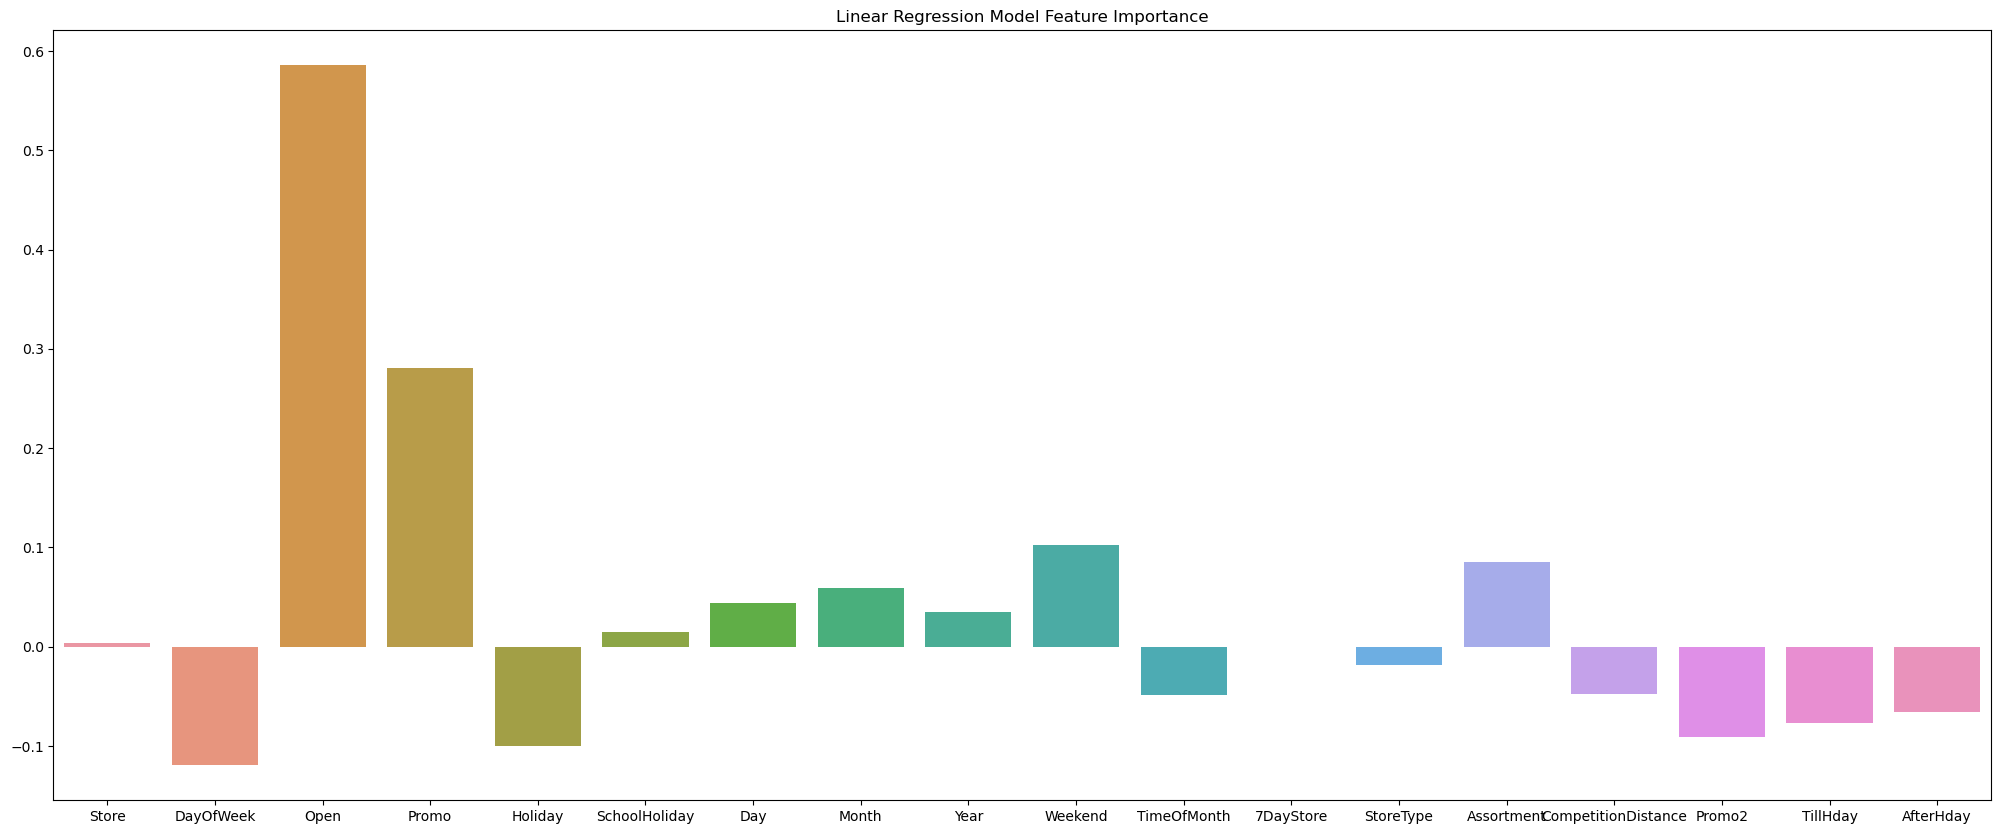

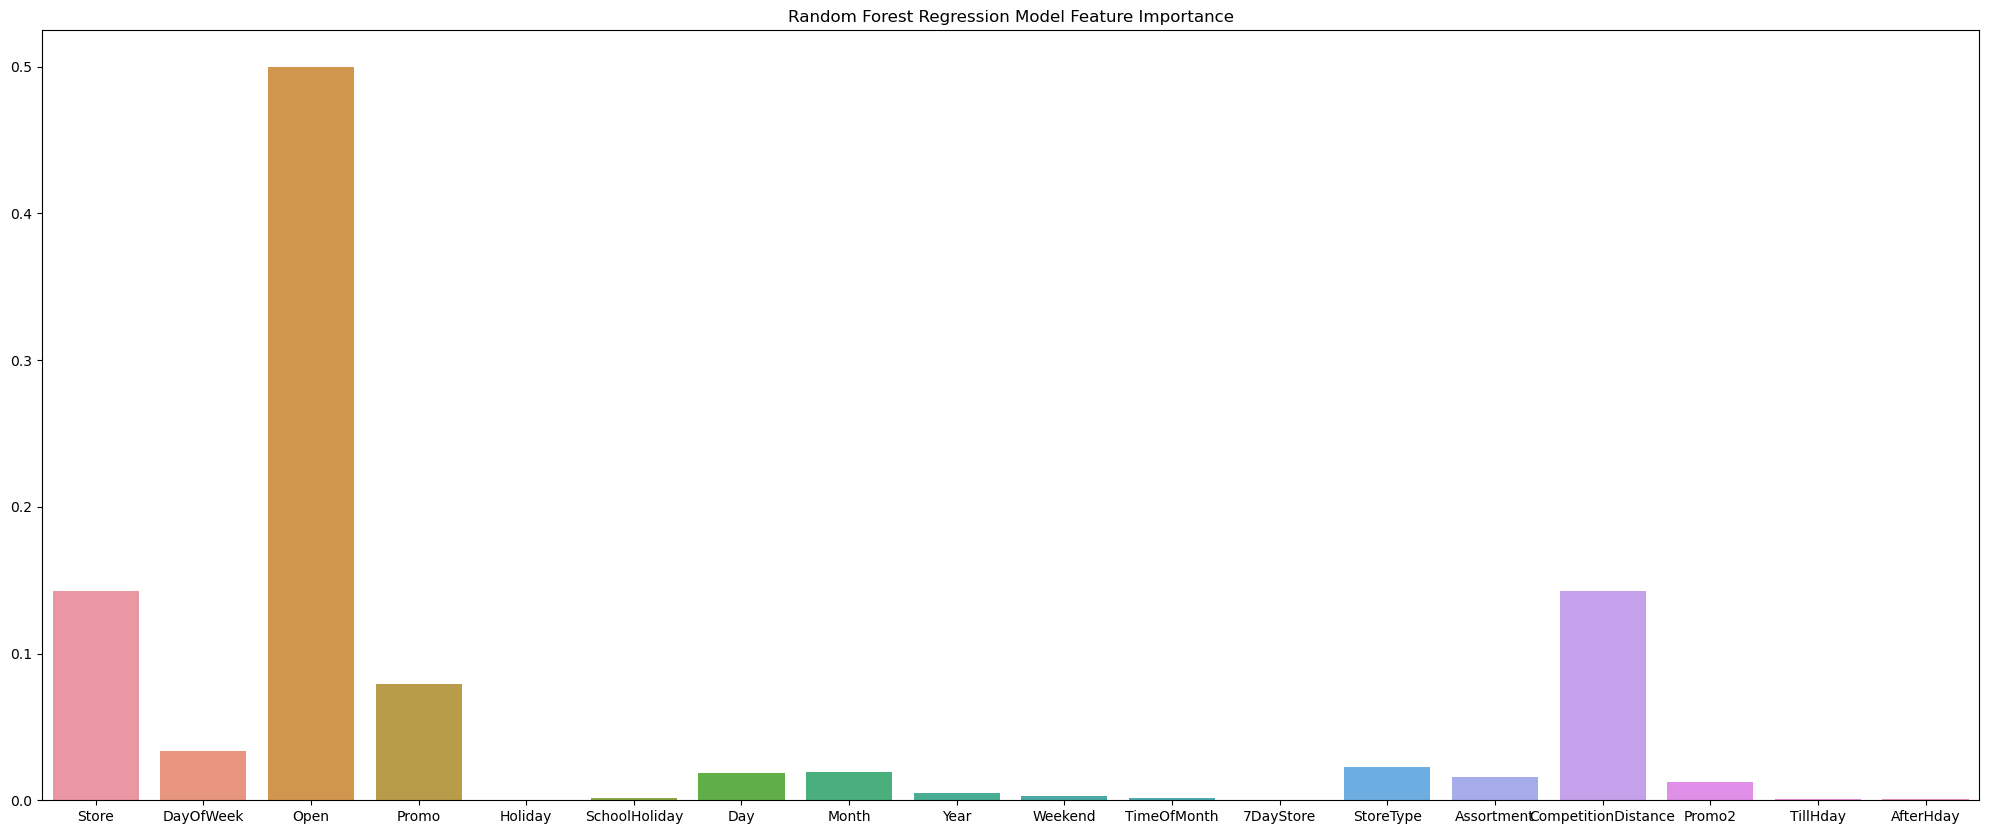

In [26]:
def featureImportance():
    #Linear Regression Model
    plt.figure(figsize=(25, 10))
    sns.barplot(x = train_features, y = reg_pipe[1].coef_[0])
    plt.title('Linear Regression Model Feature Importance')
    plt.show()

    #Random Forest Regression Model Feature Importance
    plt.figure(figsize=(25, 10))
    sns.barplot(x = train_features, y = forest_pipe[1].feature_importances_)
    plt.title('Random Forest Regression Model Feature Importance')
    plt.show()
featureImportance()

In [27]:
sales = cl_traindata['Sales'].values
split = len(sales) // 2
X1, X2 = sales[0:split], sales[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=5899.006003, mean2=5648.632188
variance1=15322001.356660, variance2=14290490.101029


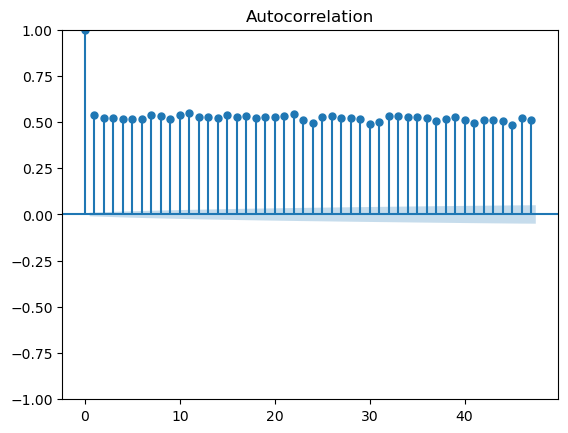

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(sales[:40000])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

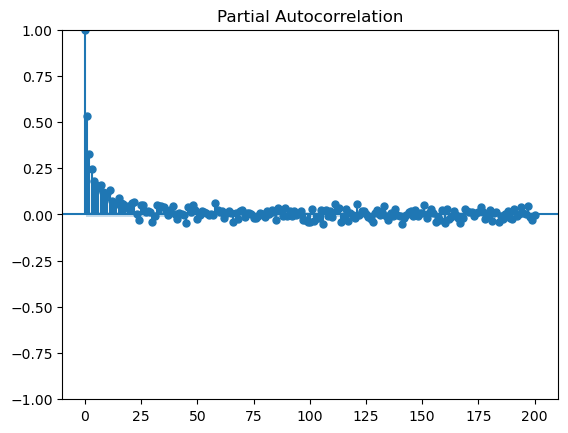

In [29]:
plot_pacf(sales[:30000], lags=200)
plt.show

In [30]:
cl_traindata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 27 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  int64         
 8   SchoolHoliday              1017209 non-null  int64         
 9   Holiday                    1017209 non-null  int64         
 10  Day                        1017209 non-null  int64         
 11  Month                      1017209 no

In [31]:
cl_traindata['Date'] = pd.to_numeric(pd.to_datetime(cl_traindata['Date']))
traindata = cl_traindata

****Scales data****

In [32]:
def scale():
    X = traindata[['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'Holiday', 'SchoolHoliday', 'Day',
              'Month', 'Year', 'Weekend' ,'TimeOfMonth', '7DayStore','StoreType',
              'Assortment','CompetitionDistance', 'Promo2', 'TillHday', 'AfterHday']][traindata['Store'] == 16].values[:10000]
    sc_x = StandardScaler()
    X = sc_x.fit_transform(X)
    y = X[:, [-1]][7:]
    print(X.shape, y.shape)
    return X, y
    
def window(array, size):
    l = []
    for i in range(len(array)-size):
        l.append(array[i:i+size])
    return np.array(l)
X, y = scale()
w = window(X, 7)
print(w.shape)

(942, 19) (935, 1)
(935, 7, 19)


2024/02/06 01:08:04 INFO mlflow.tracking.fluent: Experiment with name 'mlops-down1' does not exist. Creating a new experiment.


Train the model

Epoch 1/50

28/28 [==============================] - 5s 35ms/step - loss: 0.7103 - val_loss: 0.0033
Epoch 2/50
28/28 [==============================] - 0s 12ms/step - loss: 0.2763 - val_loss: 8.3499e-04
Epoch 3/50
28/28 [==============================] - 0s 12ms/step - loss: 0.2405 - val_loss: 6.4877e-04
Epoch 4/50
28/28 [==============================] - 0s 11ms/step - loss: 0.2690 - val_loss: 7.6022e-04
Epoch 5/50
28/28 [==============================] - 0s 12ms/step - loss: 0.2722 - val_loss: 0.0034
Epoch 6/50
28/28 [==============================] - 0s 12ms/step - loss: 0.2513 - val_loss: 9.5156e-04
Epoch 7/50
28/28 [==============================] - 0s 11ms/step - loss: 0.2302 - val_loss: 6.0837e-04
Epoch 8/50
28/28 [==============================] - 0s 12ms/step - loss: 0.2031 - val_loss: 0.0046
Epoch 9/50
28/28 [==============================] - 0s 14ms/step - loss: 0.2721 - val_loss: 8.4831e-04
Epoch 10/50
28/28 [==============================] - 0s 12ms/step -

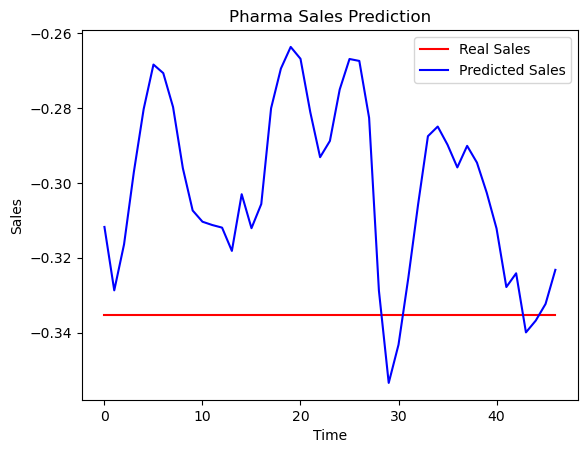

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Set the tracking URI
mlflow.set_tracking_uri('http://127.0.0.1:5000')

# Set the experiment
mlflow.set_experiment('mlops-down1')

#train and test split
X_train, X_test, y_train, y_test = w[:int(len(w)*95/100)], \
w[int(len(w)*95/100):], y[:int(len(w)*95/100)], y[int(len(w)*95/100):]

#train the model
def train():
    regressor = Sequential()
    regressor.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(7, 19)))
    regressor.add(LSTM(25, activation='relu'))
    regressor.add(Dense(1))
    regressor.add(Dropout(0.2))
    optimizer = Adam(learning_rate=0.001)
    regressor.compile(optimizer=optimizer, loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    regressor.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[early_stopping], epochs=50)
    return regressor

#test the model    
def test(regressor):
    y_pred = regressor.predict(X_test)
    print('r2 score:', r2_score(y_test, y_pred))
    print('mean squared error:', mean_squared_error(y_test, y_pred))
    plt.plot(y_test, color = 'red', label = 'Real Sales')
    plt.plot(y_pred, color = 'blue', label = 'Predicted Sales')
    plt.title('Pharma Sales Prediction')
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

print('Train the model')
regressor = train()
print('Test the model')
test(regressor)